<h1 align="center"> Computación Cientifica - Laboratorio 3: Simulando Númericamente Sistemas Dinámicos </h1>
<br>
<br>
** Autores **:
+ Yerson Escobar - 201273084-8 
+ Eduardo Ramírez - 201103031-1


## Introducción

## Desarrollo

### Simulando sistemas caóticos

### Módulos y funciones necesarias

In [1]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
#%load_ext memory_profiler
#%load_ext line_profiler
%matplotlib inline 
#no funciona esto

### Función para visualizar resultados

In [3]:
"""
-> x_t
   arreglo con las posiciones (x,y,z) de las trayectorias. Este puede ser
   de dos dimensiones (len(t), 3) para una sola trayectoria, o puede ser 
   de tres dimensiones (len(t), 3, N_trajectories) para mas de una trayectoria
-> N_trajectories
   numero de trayectorias a visualizar
-> xlim,ylim,zlim
   limites en los ejes x,y,z de la animacion
-> rotate
   rotar mientras anima para mejores perspectivas
"""
def animate_lorenz(x_t, N_trajectories, xlim=(-20,70), ylim=(-35,35), zlim=(-35,35), rotate=False):
    #setting it to correct format
    if x_t.ndim==2:
        x_t = np.array([x_t])
    elif x_t.ndim==3: 
        x_t = np.rot90(x_t).T
    else:
        return -1
    #setting the number of frames
    frames = max(x_t.shape)
    frames /= 2
    #set up figure & 3D axis for animation
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    #ax.axis('off')

    #choose a different color for each trajectory
    colors = plt.cm.jet(np.linspace(0, 1, N_trajectories))

    #set up lines and points
    lines = sum([ax.plot([], [], [], '-', c=c)
                 for c in colors], [])
    pts = sum([ax.plot([], [], [], 'o', c=c)
               for c in colors], [])

    #prepare the axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)

    #set point-of-view: specified by (altitude degrees, azimuth degrees)
    ax.view_init(30, 0)

    #initialization function: plot the background of each frame
    def init():
        for line, pt in zip(lines, pts):
            line.set_data([], [])
            line.set_3d_properties([])

            pt.set_data([], [])
            pt.set_3d_properties([])
        return lines + pts

    #animation function.  This will be called sequentially with the frame number
    def animate(i):
        # we'll step two time-steps per frame.  This leads to nice results.
        i = (2 * i) % x_t.shape[1]

        for line, pt, xi in zip(lines, pts, x_t):
            x, y, z = xi[:i].T
            line.set_data(x, y)
            line.set_3d_properties(z)

            pt.set_data(x[-1:], y[-1:])
            pt.set_3d_properties(z[-1:])

        if rotate: ax.view_init(30, 0.3 * i)
        fig.canvas.draw()
        return lines + pts

    #instantiate the animator.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=frames, interval=30, blit=True, repeat=False)
    #show it
    ax.set_title('Lorenz Simulation')
    ax.set_xlabel('x(t)')
    ax.set_ylabel('y(t)')
    ax.set_zlabel('z(t)')
    plt.show()

a.-

In [4]:
def euler_ode(func,y0,t,h):
    t_size = t.size
    solutions = np.zeros((t.size,y0.size))
    solutions[0] = y0 
    for i in range(1, t_size):
        solutions[i] = solutions[i-1]+h*func(t[i-1],solutions[i-1])
    return solutions

def midpoint_ode(func,y0,t,h):
    t_size = t.size
    solutions = np.zeros((t.size,y0.size))
    solutions[0, :] = y0 
    for i in range(1, t_size):
        current_t = t[i-1]
        y = solutions[i-1]
        k1 = y + h/2.0*func(current_t,y)
        solutions[i] = y + h*func(current_t + h/2.0,k1)
    return solutions

def RK4_ode(func,y0,t,h):
    t_size = t.size
    solutions = np.zeros((t.size,y0.size))
    solutions[0, :] = y0
    for i in range(1, t_size):
        current_t = t[i-1]
        y = solutions[i-1]
        k1=func(current_t,y)
        k2=func(current_t+h/2.0,y+(h/2.0)*k1)        
        k3=func(current_t+h/2.0,y+(h/2.0)*k2)
        k4=func(current_t+h,y+h*k3)
        solutions[i] = y+(h/6.0)*(k1+2*k2+2*k3+k4)
    return solutions

b.- Se analizaran los valores de $h$ con que el sistema podrá ser solucionado 

$$
\vec{F}(\vec{x}) = 
\left( \begin{array}{c}
\sigma(y-x) \\
x(\rho-z)-y \\
xy - \beta z \end{array} \right)
\Longrightarrow
\partial\vec{F}(\vec{x}) =
\left( \begin{array}{ccc}
-\sigma & \sigma & 0\\
\rho-z & -1 & -x \\
y & x & -\beta\end{array} \right)
$$

Si los parametros son como se indica en el enunciado y $\vec{x_0} = (1,1,1)$ entonces

$$
\left|\partial\vec{F}(\vec{x_0}) - \lambda I \right| = -\lambda ^3-\frac{41 \lambda ^2}{3}+\frac{689 \lambda }{3}+\frac{2020}{3}
$$

Encontrando las raices:
$$
\lambda_1 = 11.4713 - 7.10543\cdot10^{-15} i
$$
$$
\lambda_2 = -22.533 - 5.32907\cdot10^{-15} i
$$
$$
\lambda_3 = -2.60495 + 1.24345\cdot10^{-14} i
$$

Finalmente $h$ debe cumplir

$$
0 < h < 0.088
$$
$$
0 < h < 0.768
$$

Entonces $h = 0.087$


In [66]:
def LorentzAtractor(t, xvect):
    _x = xvect[0]
    _y = xvect[1]
    _z = xvect[2]
    next_x = sigma*(_y-_x)
    next_y = _x*(rho-_z)-_y
    next_z = _x*_y - beta*_z
    return np.array([next_x,next_y,next_z])
    
sigma = 10
rho = 28
beta = 8/3
xvect0 = np.array([1.0, 1.0, 1.0])

#El mejor h que funciona con todos fue encontrado por ensayo y error usando Euler.
#Los otros dos métodos, al tener mejor región de estabilidad, funcionan con este h, aun que cada uno tiene su propia cota
#encontrada de la misma forma. 
h = 0.024

t = np.arange(0,100,h)

In [67]:
x_euler = euler_ode(LorentzAtractor,xvect0,t,h) #falla con h>= 0.025
animate_lorenz(x_euler,1)

In [68]:
x_midpoint = midpoint_ode(LorentzAtractor,xvect0,t,h) #falla con h >=  0.07
animate_lorenz(x_midpoint,1)

In [69]:
x_RK4 = RK4_ode(LorentzAtractor,xvect0,t,h) #falla con h >= 1.4
animate_lorenz(x_RK4,1)

c.-

In [12]:
t = np.arange(0,1000,h)
x_euler = euler_ode(LorentzAtractor,xvect0,t,h) 
%timeit -r 1 animate_lorenz(x_euler,1)

1 loops, best of 1: 1.34 s per loop


In [13]:
x_midpoint = midpoint_ode(LorentzAtractor,xvect0,t,h) 
%timeit -r 1 animate_lorenz(x_midpoint,1)

The slowest run took 164.93 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 1: 577 ms per loop


In [ ]:
x_RK4 = RK4_ode(LorentzAtractor,xvect0,t,h) 
%timeit -r 1 animate_lorenz(x_RK4,1)

d.- analisis para despues

e.-

In [6]:
def parallel_euler_ode(func,y0,t,h):
    t_size = t.size
    num_tray = y0.shape[1]
    solutions = np.zeros((t.size,3,num_tray))
    solutions[0]= y0
    for i in range(1,t_size):
        for i_tray in range(0, num_tray):
            prev_y = solutions[i-1][:,i_tray]
            prev_t = t[i-1]
            solutions[i][:,i_tray] = prev_y + h*func(prev_t,prev_y)
    return solutions

def parallel_midpoint_ode(func,y0,t,h):
    t_size = t.size
    num_tray = y0.shape[1]
    solutions = np.zeros((t.size,3,num_tray))
    solutions[0]= y0
    for i in range(1, t_size):
        for i_tray in range(0, num_tray):
            prev_t = t[i-1]
            prev_y = solutions[i-1][:,i_tray]
            k1 = prev_y + h/2.0*func(prev_t,prev_y)
            solutions[i][:,i_tray] = prev_y + h*func(prev_t + h/2.0,k1)
    return solutions

def parallel_RK4_ode(func,y0,t,h):
    t_size = t.size
    num_tray = y0.shape[1]
    solutions = np.zeros((t.size,3,num_tray))
    solutions[0]= y0
    for i in range(1, t_size):
        for i_tray in range(0, num_tray):
            prev_t = t[i-1]
            prev_y = solutions[i-1][:,i_tray]
            k1=func(prev_t,prev_y)
            k2=func(prev_t+h/2.0,prev_y+(h/2.0)*k1)        
            k3=func(prev_t+h/2.0,prev_y+(h/2.0)*k2)
            k4=func(prev_t+h,prev_y+h*k3)
            solutions[i][:,i_tray]  = prev_y+(h/6.0)*(k1+2*k2+2*k3+k4)
    return solutions

In [ ]:
x_0 = np.array([[1,2,3],[1,2,3],[1,2,3]])
x = parallel_RK4_ode(LorentzAtractor,x_0,t,h) 
animate_lorenz(x,x_0.shape[1],rotate=True)

f.- 

In [9]:
p1 = np.array([1,1,1])
p2 = np.array([1,1,1-0.000009])
x_0 = np.zeros((3,2))
x_0[:,0] = p1
x_0[:,1] = p2
t = np.arange(0,50,h)

In [10]:
x = parallel_euler_ode(LorentzAtractor,x_0,t,h) 
animate_lorenz(x,x_0.shape[1],rotate=True)

In [25]:
x = parallel_midpoint_ode(LorentzAtractor,x_0,t,h) 
animate_lorenz(x,x_0.shape[1],rotate=True)

In [23]:
x = parallel_RK4_ode(LorentzAtractor,x_0,t,h) 
animate_lorenz(x,x_0.shape[1],rotate=True)

Se usaron puntos con iguales coordenadas en el plano XY, pero con una diferencia de 0.000009 en el eje Z. Como podemos ver en las animaciones, en las primeras posiciones ambos puntos parecen estar juntos, pero la verdad es que hay una distancia imperceptible. Además ambos puntos se mueven de la misma forma en el espacio. Luego de unas iteraciones, la distancia se vuelve clara y los movimientos dejan de ser iguales, cada punto toma un rumbo distinto. Esto demuestra claramente el comportamiento de sistemas caóticos, ya que una pequeña variación en las condiciones iniciales causa soluciones completamente distintas en el tiempo. El método de Euler genera soluciones que comienzan a diverger a los 35 segundos de simulación aproximadametne, mientras que Midpoint comienza a los 50 y RK4 demora 65. Esto  se debe a la presición con las que calculan cada solución, siendo RK4 el más preciso.

g.-

In [15]:
r = 0.000009
x_0 = np.zeros((3,20))
for i in range(20):
    x_0[:,i] = np.array([1,1,1+r/19*i])
x = parallel_RK4_ode(LorentzAtractor,x_0,t,h) 
animate_lorenz(x,x_0.shape[1],rotate=True)

Todos los puntos tienen coordenadas iguales en plano XY, y la coordenada z se reparte entre los 20 puntos de manera equiespaciada entre 1 y 1.000009. A los 80 segundos de simulación aproximadamente se ve la divergencia máxima de todos los puntos. Cada uno toma una ruta distinta, y jamás vuelven a alinearse como en un principio, mostrando un comportamiento caótico.

### BVP de orden superior

a) Definiremos las siguientes variables:

$$ \begin{matrix}
   y_1 = y(t) \\
   y_2 = y'(t) \\
   y_3 = y''(t) \\
   y_4 = y^{(3)}(t) \\
   \end{matrix} $$

En base a estas nuevas variables, podemos expresar el BVP anterior en el siguiente sistema de IVP:

$$ \begin{align}
   y_1' &= y_2 \\
   y_2' &= y_3 \\
   y_3' &= y_4 \\
   y_4' &= -y_1 \\
   y_1(0) &= 0 \\
   y_2(0) &= \alpha \\
   y_3(0) &= \beta \\
   y_4(0) &= \gamma
   \end{align} $$
   
En donde $ \alpha $, $ \beta $, $ \gamma $ son constantes auxiliares que representan la condición inicial de las variables $ y_2 $, $ y_3 $, $ y_4 $.

b) Partiendo de la aproximación de $ y''(x) = \frac{y(x+h) - 2y(x) + y(x-h)}{h^2} + O(h^2)$, aproximaremos la cuarta derivada. Usando la misma técnica de aproximación:

* Tercera derivada:

$$ \begin{align}
   y'''(x) = \frac{y''(x) - y''(x - h)}{h} \implies y'''(x) &= \frac{\frac{y(x+h) - 2y(x) + y(x-h)}{h^2} - \frac{y(x) - 2y(x-h) + y(x-2h)}{h^2}}{h} \\ 
   &= \frac{y(x+h)-3y(x)+3y(x-h)-y(x-2h)}{h^3}
   \end{align} $$
   
* Cuarta derivada:

$$ \begin{align}
   y^{(4)}(x) = \frac{y'''(x) - y'''(x - h)}{h} \implies y^{(4)}(x) &= \frac{\frac{y(x+h) - 3y(x) + 3y(x-h) - y(x-2h)}{2h^3} - \frac{y(x) - 3y(x-h) + 3y(x-2h) - y(x-3h)}{h^3}}{h} \\ 
   &= \frac{y(x+h) - 4y(x) + 6y(x-h) - 4y(x-2h) + y(x-3h)}{h^4}
   \end{align} $$

Para discretizar, sea $ x_i = i \cdot \Delta x $, con $ \Delta x = \frac{1}{N} $ el largo de los intervalos escogidos y $ N $ el número de puntos; y $ u_i = y(x_i) $ la discretización del dominio de la función, con $ x_i \in [0,2] $. Para el BVP, la discretización tiene la siguiente forma:


$$ \begin{align}
   \frac{u_{i+1} - 4u_{i} + 6u_{i-1} - 4u_{i-2} + u_{i-3}}{h^4} &= -u_i \\
   \frac{1}{h^4}u_{i+1} - \left(\frac{4}{h^4} - 1 \right)u_i + \frac{6}{h^4}u_{i-1} - \frac{4}{h^4}u_{i-2} + \frac{1}{h^4}u_{i-3} &= 0 \qquad \forall i \in 0:N
   \end{align} $$
<br>
<br>
c) Asumiendo que el dominio del BVP es $ [0,2] $, la función fue implementada de la siguiente forma:

In [120]:
def solve_BVPIV(N):
    xi = np.linspace(0,2,N)
    size = np.size(xi)
    delta = xi[1] - xi[0]
    
    F = np.zeros([size, size])
    F[0,0] = 1.
    F[size-1,size-1] = 1.
    F[size-2,size-2:] = np.array([-1./delta, 1./delta])
    F[size-3,size-3:] = np.array([1./delta**2, -2./delta**2, 1./delta**2])
    for i in range(1,size-3):
        F[size - 3 - i, size-4-i:size+1-i] = np.array([1./delta**4, -4./delta**4, 6./delta**4, -4./delta**4 + 1., 1./delta**4])
    
    b = np.zeros(size)
    b[size-3:] = np.array([1.,-1.,1.])
    
    return np.linalg.solve(F,b)

d) Los gráficos son los siguientes:

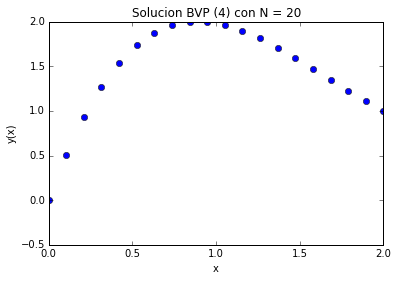

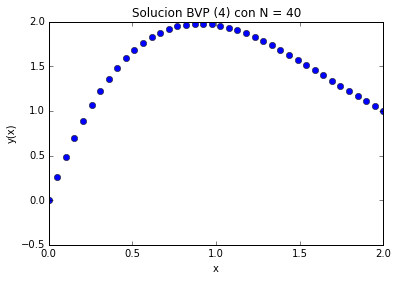

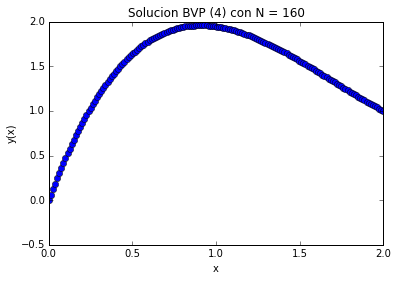

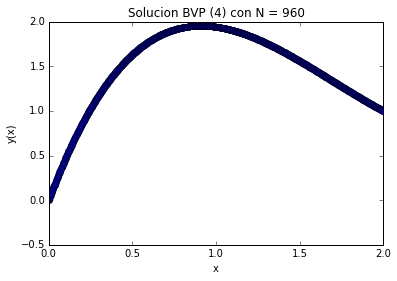

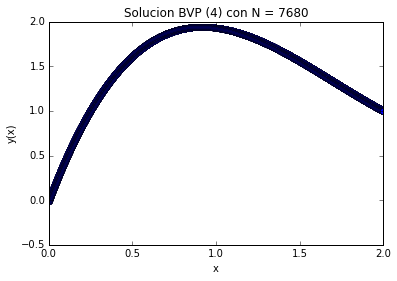

In [121]:
N = (20, 40, 160, 960, 7680)

for i in N:
    plt.plot(np.linspace(0,2,i), solve_BVPIV(i), 'o', label="N = " + str(i))
    plt.title("Solucion BVP (4) con N = " + str(i))
    plt.ylabel("y(x)")
    plt.xlabel("x")
    plt.show()

Como se puede ver, a medida que aumentamos h, podemos aumentar la precisión de la solución $ y(x) $, lo cuál se demuestra en los gráficos de arriba, en donde la función se va por sobre los límites del gráfico con valores que pueden superar un poco el $ 2 $. A medida que aumentamos $ N $, además de poder tener una mejor visión de como se comporta la función, se nota que los valores ya no van por sobre $ 2 $, por lo que nos aseguramos que la función encontrada es más precisa.

## Conclusión

## Referencias